In this project, an LSTM was created to differentiate between real and fake news. A pre-made dataset was taken from online sources for this task. Natural Language Processing (NLP) techniques were used to convert text into numerical representations for the model to process. The model was trained on a Google Colab environment using a T4 GPU to accelerate the training process.

In [1]:
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
import tensorflow as tf
import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
#Linking Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
#Importing dataframes
df_false = pd.read_csv('/content/gdrive/MyDrive/data/Fake.csv')
df_true = pd.read_csv('/content/gdrive/MyDrive/data/True.csv')

Mounted at /content/gdrive


The dataset used for this project contains several columns that help in identifying and processing news articles for fake news detection. Key columns in the dataset include:

True: A binary column where 1 indicates real news and 0 indicates fake news.

Title: Contains the headline of the news article.

Text: Contains the body text of the news article.

Date: Provides the date when the news article was published.

Subject: Indicates the general topic covered by the news article, such as politics, world, etc.

By examining these columns, we can preprocess the data for training the LSTM model. The "Title" and "Text" columns are particularly important as they provide the textual data that the model will use to learn and differentiate between real and fake news.

In [9]:
print(df_true.isnull().sum())
print(df_false.isnull().sum())

title      0
text       0
subject    0
date       0
isfake     0
dtype: int64
title      0
text       0
subject    0
date       0
isfake     0
dtype: int64


There are no NULL values in either of the dataframes. To proceed, we need to do some feature engineering by removing unnecessary features and creating new, improved features for the algorithm.

By creating the isfake column, we can label real news with 0 and fake news with 1. Combining the df_false and df_true dataframes into a single dataframe makes it easier to process. The content column is created by merging the title and text columns, providing a unified text input for the model. Finally, we drop the date, title, and text columns, as they are no longer needed.

In [10]:
#Feature Engineering
df_true['isfake'] = 0
df_false['isfake'] = 1
df = pd.concat([df_false, df_true]).reset_index(drop=True) #Combining both for input DF
#Creating a single content column by combining text and title
df['content'] = df['title'] + " " + df['text']
#Date column is of no use
df.drop(columns = ['date', 'title', 'text'], inplace = True)
df.head()

,subject,isfake,content
0,News,1,Donald Trump Sends Out Embarrassing New Year’...
1,News,1,Drunk Bragging Trump Staffer Started Russian ...
2,News,1,Sheriff David Clarke Becomes An Internet Joke...
3,News,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,News,1,Pope Francis Just Called Out Donald Trump Dur...


To ensure the LSTM model receives the most relevant words, we will remove stopwords such as "a," "the," etc. This step helps in creating a new set of articles that, while not grammatically correct, are better suited for the model's learning process.

By removing stopwords, we create a more streamlined dataset where each article is reduced to its most essential words. This enhances the model's ability to detect patterns and differentiate between real and fake news.

In [11]:
#Data Cleaning
#Removing stopwords
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'edu', 'use', 're']) #Adding news specific stopwords
#Creating a function to remove
def remover(content):
    result = []
    for i in gensim.utils.simple_preprocess(content):
        #Only keep words:
        #Greater than 2 char, not in stop_words list
        if i not in gensim.parsing.preprocessing.STOPWORDS and len(i) > 3 and i not in stop_words:
            result.append(i)
    return result
#Cleaning dataframe
df['cl_content'] = df['content'].apply(remover)
#Stringing everything back together
df['cl_content_final'] = df['cl_content'].apply(lambda x: " ".join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The effect of this exercise is as follows.

In [12]:
print("BEFORE CLEANING:", df['content'][0])
print("AFTER CLEANING:", df['cl_content_final'][0])

BEFORE CLEANING:  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s gre

To understand the kind of data we have and identify the most frequent terms, we can create visualizations such as word clouds and bar charts.

In [13]:
#Exploratory data analysis
df

,subject,isfake,content,cl_content,cl_content_final
0,News,1,Donald Trump Sends Out Embarrassing New Year’...,"[donald, trump, sends, embarrassing, year, mes...",donald trump sends embarrassing year message d...
1,News,1,Drunk Bragging Trump Staffer Started Russian ...,"[drunk, bragging, trump, staffer, started, rus...",drunk bragging trump staffer started russian c...
2,News,1,Sheriff David Clarke Becomes An Internet Joke...,"[sheriff, david, clarke, internet, joke, threa...",sheriff david clarke internet joke threatening...
3,News,1,Trump Is So Obsessed He Even Has Obama’s Name...,"[trump, obsessed, obama, coded, website, image...",trump obsessed obama coded website images chri...
4,News,1,Pope Francis Just Called Out Donald Trump Dur...,"[pope, francis, called, donald, trump, christm...",pope francis called donald trump christmas spe...
...,...,...,...,...,...
44893,worldnews,0,'Fully committed' NATO backs new U.S. approach...,"[fully, committed, nato, backs, approach, afgh...",fully committed nato backs approach afghanista...
44894,worldnews,0,LexisNexis withdrew two products from Chinese ...,"[lexisnexis, withdrew, products, chinese, mark...",lexisnexis withdrew products chinese market lo...
44895,worldnews,0,Minsk cultural hub becomes haven from authorit...,"[minsk, cultural, authorities, minsk, reuters,...",minsk cultural authorities minsk reuters shado...
44896,worldnews,0,Vatican upbeat on possibility of Pope Francis ...,"[vatican, upbeat, possibility, pope, francis, ...",vatican upbeat possibility pope francis visiti...


<Axes: xlabel='count', ylabel='isfake'>

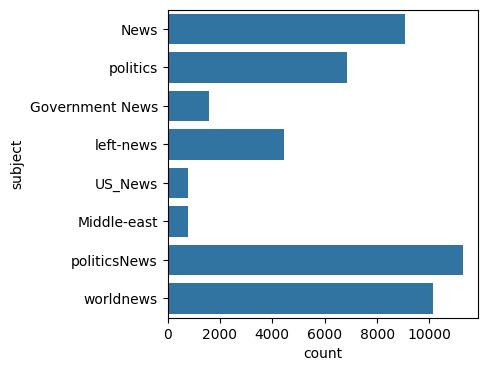

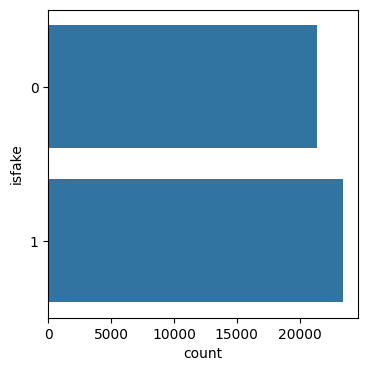

In [14]:
#Getting to know what are the various topics covered in the news
plt.figure(figsize = (4,4))
sns.countplot(y= "subject", data = df)
#Getting a count of how much fake news is there compared to real news
plt.figure(figsize = (4,4))
sns.countplot(y = "isfake", data = df)

By visualizing the dataset, we can draw several insights:

Balance of Data: The dataset contains a roughly equal number of fake news and real news articles, providing a balanced training set for the model.

Prevalence of Topics: World news and politics are the most prevalent topics in our training data, indicating these subjects are frequently covered in both fake and real news articles.

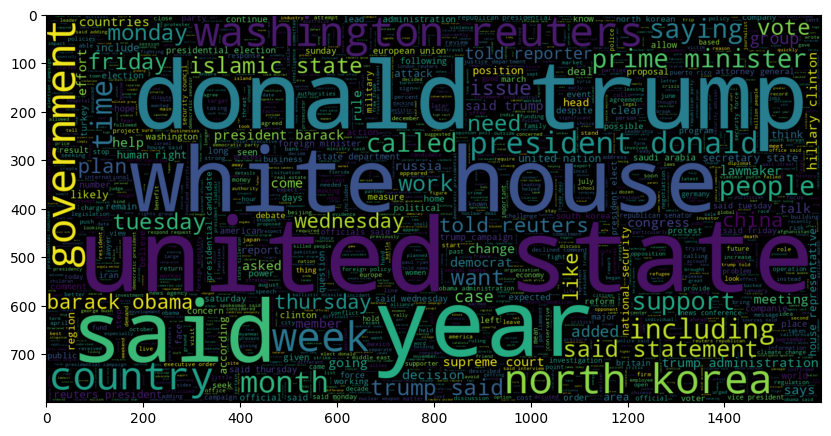

In [15]:
#Trying to figure out what are the most common words in real news
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].cl_content_final))
plt.imshow(wc, interpolation = 'bilinear')

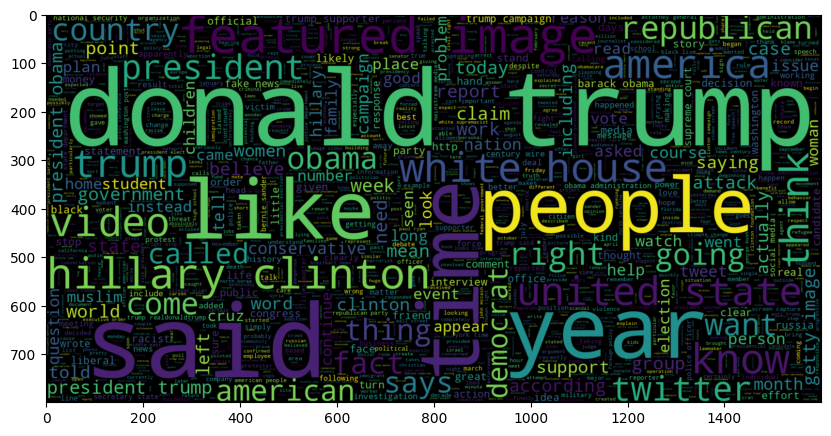

In [16]:
#Trying to figure out what are the most common words in fake news
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].cl_content_final))
plt.imshow(wc, interpolation = 'bilinear')

In [17]:
max = -1
for piece in df.cl_content_final:
    tokens = nltk.word_tokenize(piece)
    if(max<len(tokens)):
        max = len(tokens)
print("The maximum number of words is:", max)

The maximum number of words is: 4405


To tokenize the text data and prepare it for the LSTM model, we need to determine the maximum number of unique words in a single content entry for padding purposes. This ensures that all input sequences have the same length.

In [18]:
#Preparing the data
#Train-test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.cl_content_final, df.isfake, test_size = 0.2)
#Tokenising
#Overall list of unique words
words = []
for i in df.cl_content:
    for j in i:
        words.append(j)
words = list(set(words))
wordsnum = len(words)
print(wordsnum)

108704


In [19]:
from nltk import word_tokenize

Convert the text data into sequences of integers where each integer represents a unique word in the corpus.

In [20]:
#Make tokens using nltk
tokenizer = Tokenizer(num_words = wordsnum)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)
#len(train_sequences)
#len(test_sequences)

Pad shorter sequences with zeros to ensure all sequences have the same length.

In [21]:
#Padding is done so that all samples are of the same length
from keras.utils import pad_sequences
padded_train = pad_sequences(train_sequences, maxlen = 4405, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 40, truncating = 'post')

The LSTM model is constructed with an embedding layer, a bidirectional LSTM layer, and dense layers to process the text data for fake news detection. Embedding layer will help reduce computational complexity, Bidirectional layer allows understanding of both future and past context in the sentence and finally the dense layer allows for capturing of complex patterns and the sigmoid layer allows for a probability score for binary classification.

In [22]:
#Building the model
model = Sequential()

#Embedding layer to save computational resources
model.add(Embedding(wordsnum, output_dim = 128))
#LSTM
model.add(Bidirectional(LSTM(128)))
#Layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         13914112  
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14210305 (54.21 MB)
Trainable params: 14210305 (54.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
y_train = np.asarray(y_train)
#Train the model
model.fit(padded_train, y_train, batch_size=64, validation_split=0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 208s 398ms/step - loss: 0.0414 - acc: 0.9829 - val_loss: 0.0028 - val_acc: 0.9997
Epoch 2/2
506/506 [==============================] - 194s 382ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0034 - val_acc: 0.9992


Now that the model is trained, we will try to gauge the performance of the model.

In [25]:
#Model performance
y_test_pred = model.predict(padded_test)
#Converting to Binary
prediction = []
for i in range(len(y_test_pred)):
    if y_test_pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
#Accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(list(y_test), prediction)
print("Accuracy:", accuracy)

281/281 [==============================] - 2s 3ms/step
Accuracy: 0.9989977728285078


We have gotten a freakishly high accuracy on the testing set.

<Axes: >

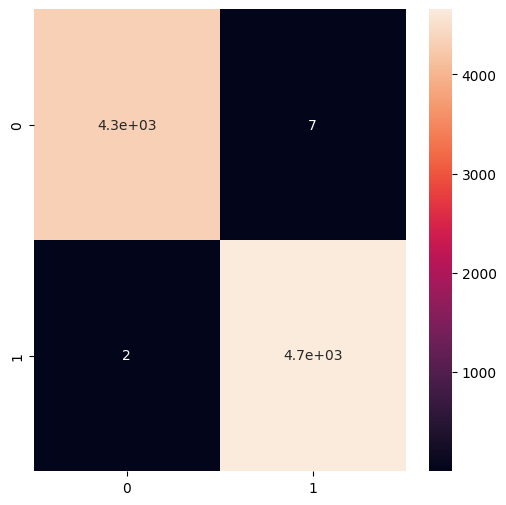

In [27]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True)

The confusion matrix shows us there are only 9 mislabelled examples.